In [1]:
import pandas as pd 
import numpy as np 
from umap import UMAP
import pickle
from pyspark.sql.functions import *
from pyspark.mllib.evaluation import RankingMetrics
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.ml.recommendation import ALS
spark = SparkSession.builder.config("spark.driver.memory", "15g").config("spark.driver.maxResultSize", "15g").appName('umap_impl').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/16 17:02:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/16 17:02:55 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [2]:
path = "/home/mb7979/final-project-group_69/"
train_file_path = path + "merge_train_large.csv"
test_file_path = path + "merge_test_large.csv"
train_data = spark.read.option("header", "false").csv(train_file_path, schema = 'userId INT, movieId INT, rating FLOAT, genres STRING')
test_data = spark.read.option("header", "false").csv(test_file_path, schema = 'userId INT, movieId INT, rating FLOAT, genres STRING')

In [4]:
train_data.show()

+------+-------+------+--------------------+
|userId|movieId|rating|              genres|
+------+-------+------+--------------------+
|     1|    481|   3.5|      Drama|Thriller|
|     1|   1091|   1.5|              Comedy|
|     1|   1257|   4.5|      Comedy|Romance|
|     1|   1449|   4.5|              Comedy|
|     1|   1590|   2.5|Horror|Sci-Fi|Thr...|
|     1|   1591|   1.5|Action|Adventure|...|
|     1|   2134|   4.5|Comedy|Fantasy|Sc...|
|     1|   2478|   4.0|      Comedy|Western|
|     1|   2986|   2.5|Action|Crime|Sci-...|
|     1|   3020|   4.0|        Action|Drama|
|     1|   3424|   4.5|               Drama|
|     1|   3698|   3.5|       Action|Sci-Fi|
|     1|   3826|   2.0|Horror|Sci-Fi|Thr...|
|     1|   3893|   3.5|Comedy|Crime|Dram...|
|     2|    170|   3.5|Action|Adventure|...|
|     2|    849|   3.5|Action|Adventure|...|
|     2|   1186|   3.5|               Drama|
|     2|   1235|   3.0|Comedy|Drama|Romance|
|     2|   1244|   3.0|Comedy|Drama|Romance|
|     2|  

In [5]:
als = ALS(rank = 250, regParam = 1,maxIter = 10, implicitPrefs = False, userCol='userId', itemCol='movieId',ratingCol='rating', coldStartStrategy="drop", seed = 1234)
model = als.fit(train_data)

22/05/16 17:03:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
22/05/16 17:03:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
22/05/16 17:03:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
22/05/16 17:03:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
22/05/16 17:03:47 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the f

In [6]:
latent_item_factors = model.itemFactors

/home/mb7979/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
column_names = ["id", "movieId", "rating", "genres"]
train_data = train_data.toDF(*column_names)
train_data = train_data.drop('movieId', 'rating')
test_data = test_data.toDF(*column_names)
test_data = test_data.drop('movieId', 'rating')

In [10]:
test_data.show()

+-----+--------------------+
|   id|              genres|
+-----+--------------------+
|  185|     Action|Thriller|
| 5352|Comedy|Drama|Romance|
| 6264|Comedy|Fantasy|Ho...|
| 7333|Comedy|Drama|Roma...|
| 8167|       Action|Sci-Fi|
| 9285|       Drama|Romance|
|11365|      Horror|Mystery|
|11612|      Crime|Thriller|
|17897|               Drama|
|21518|    Animation|Comedy|
|21991|      Drama|Thriller|
|24302|Adventure|Animati...|
|24745|Action|Crime|Dram...|
|28779|         Crime|Drama|
|29121|      Comedy|Romance|
|33998|Action|Horror|Sci...|
|34305|Action|Adventure|...|
|35247|        Comedy|Drama|
|36601|Comedy|Drama|Romance|
|37237|     Children|Comedy|
+-----+--------------------+
only showing top 20 rows



In [11]:
train_data.show()

+---+--------------------+
| id|              genres|
+---+--------------------+
|  1|      Drama|Thriller|
|  1|              Comedy|
|  1|      Comedy|Romance|
|  1|              Comedy|
|  1|Horror|Sci-Fi|Thr...|
|  1|Action|Adventure|...|
|  1|Comedy|Fantasy|Sc...|
|  1|      Comedy|Western|
|  1|Action|Crime|Sci-...|
|  1|        Action|Drama|
|  1|               Drama|
|  1|       Action|Sci-Fi|
|  1|Horror|Sci-Fi|Thr...|
|  1|Comedy|Crime|Dram...|
|  2|Action|Adventure|...|
|  2|Action|Adventure|...|
|  2|               Drama|
|  2|Comedy|Drama|Romance|
|  2|Comedy|Drama|Romance|
|  2|       Drama|Romance|
+---+--------------------+
only showing top 20 rows



In [12]:
genres_data = train_data.join(latent_item_factors, "id", "inner")

In [13]:
genres_data = genres_data.toPandas()

In [14]:
genres_data.head()

,id,genres,features
0,148,Adventure|Animation|Children|Comedy|Fantasy,"[-0.4298727, 0.47818273, 0.690545, 0.3343697, ..."
1,148,Comedy|Romance,"[-0.4298727, 0.47818273, 0.690545, 0.3343697, ..."
2,148,Comedy,"[-0.4298727, 0.47818273, 0.690545, 0.3343697, ..."
3,148,Drama|Romance,"[-0.4298727, 0.47818273, 0.690545, 0.3343697, ..."
4,148,Drama|Romance,"[-0.4298727, 0.47818273, 0.690545, 0.3343697, ..."


In [15]:
v_stack_op = np.vstack(list(genres_data.features))
v_stack_op.shape

(4062647, 10)

In [16]:
v_stack_op = StandardScaler().fit_transform(v_stack_op)

In [17]:
random_samples = np.random.choice(v_stack_op.shape[0], 400, replace=False)
np.save("random_samples.npy", random_samples)

In [19]:
from umap import UMAP

In [20]:
mapper = UMAP(verbose=True).fit(v_stack_op[random_samples])
X_embedded = mapper.transform(v_stack_op[random_samples])

UMAP( verbose=True)
Mon May 16 17:05:57 2022 Construct fuzzy simplicial set
Mon May 16 17:05:58 2022 Finding Nearest Neighbors
Mon May 16 17:05:59 2022 Finished Nearest Neighbor Search
Mon May 16 17:06:01 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon May 16 17:06:03 2022 Finished embedding


In [21]:
np.save("umap_embeddings.npy", X_embedded)

In [22]:
pickle.dump(mapper, open("umap_mapper.pkl", "wb"))

In [23]:
import umap.plot

<AxesSubplot:>

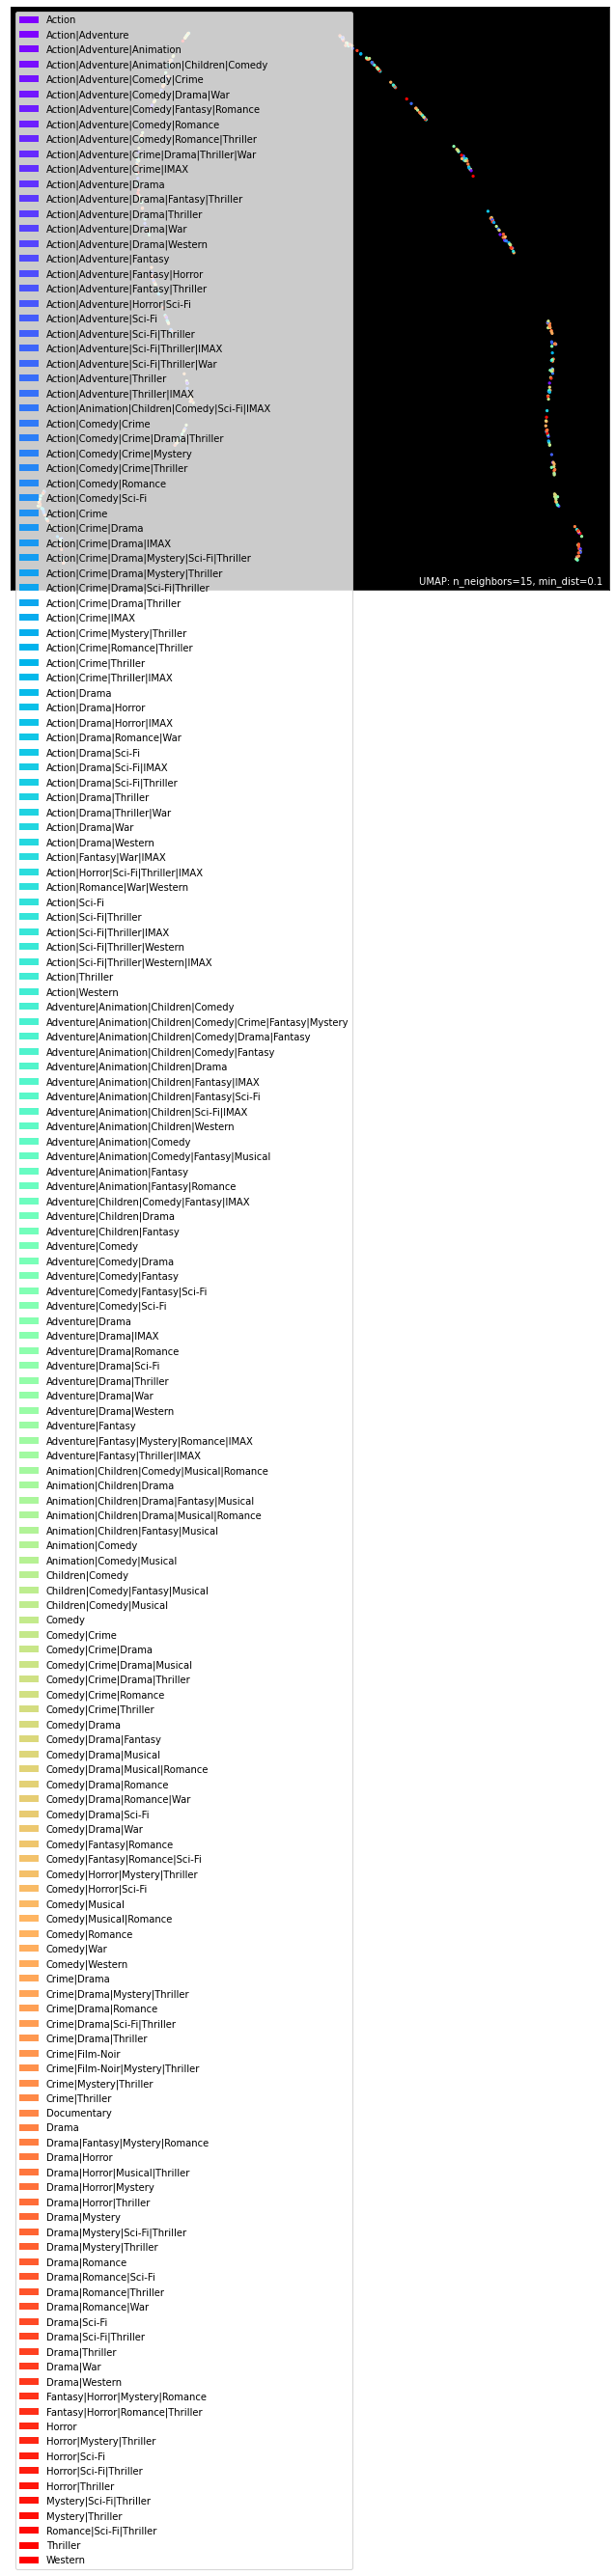

In [24]:
umap.plot.points(mapper, labels=genres_data.genres[random_samples], theme='fire')

In [25]:
import matplotlib.pyplot as plt

In [26]:
latent_users_factors = model.userFactors

/home/mb7979/.local/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [27]:
latent_users_df = latent_users_factors.toPandas()

In [28]:
latent_users_df

,id,features
0,10,"[-0.5706529, 0.63379705, 0.9141282, 0.4424731,..."
1,20,"[-0.4096407, 0.45505148, 0.6562207, 0.31757113..."
2,30,"[-0.5441797, 0.60429925, 0.8715018, 0.42183948..."
3,40,"[-0.62762845, 0.6969746, 1.0047101, 0.48611695..."
4,50,"[-0.6264908, 0.6958543, 1.0033987, 0.48557067,..."
...,...,...
281875,283179,"[-0.53157294, 0.59080076, 0.8522477, 0.412448,..."
281876,283189,"[-0.52659655, 0.584168, 0.841372, 0.40696678, ..."
281877,283199,"[-0.5788868, 0.6422312, 0.9249249, 0.44734415,..."
281878,283209,"[-0.45578685, 0.5071196, 0.732084, 0.35433578,..."


In [29]:
X_1 = np.vstack(list(latent_users_df.features))

In [31]:
X_1.shape

(281880, 10)

In [32]:
X_1 = StandardScaler().fit_transform(X_embedded)

In [34]:
samples_users_1 = np.random.choice(X_1.shape[0], 610, replace=False)

In [35]:
np.save("samples_users_1.npy", samples_users_1)

In [36]:
mapper_users = UMAP(verbose=True).fit(X_1[samples_users_1])
X_embedded = mapper_users.transform(X_1[samples_users_1])

UMAP( verbose=True)
Mon May 16 17:08:47 2022 Construct fuzzy simplicial set
Mon May 16 17:08:47 2022 Finding Nearest Neighbors
Mon May 16 17:08:47 2022 Finished Nearest Neighbor Search
Mon May 16 17:08:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Mon May 16 17:08:49 2022 Finished embedding


In [39]:
np.save("umap_embeddings_users_2.npy", X_embedded)
pickle.dump(mapper_users, open("umap_mapper_users_2.pkl", "wb"))

In [40]:
mapper_users = pickle.load(open("umap_mapper_users_2.pkl", "rb"))
X_embedded = np.load("umap_embeddings_users_2.npy")
samples_users = np.load("samples_users_1.npy")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

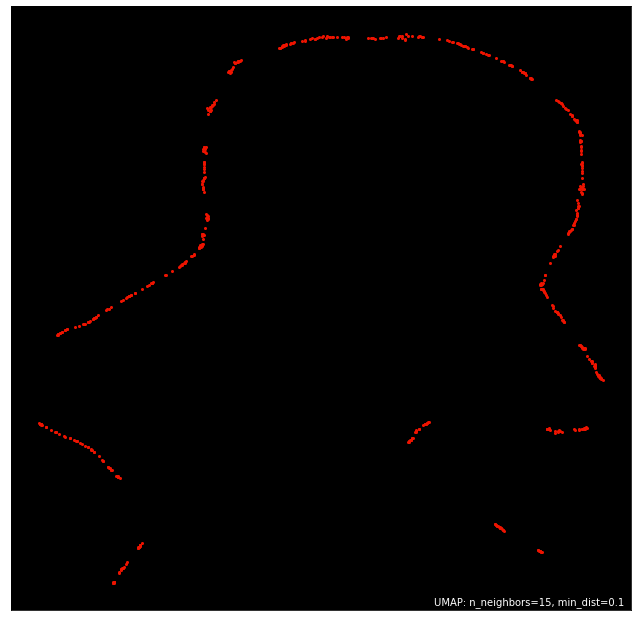

In [41]:
umap.plot.points(mapper_users, theme='fire')
